In [8]:
import pandas as pd

# Charger les fichiers CSV
train = pd.read_csv('/kaggle/input/ghana-crop-disease/Train.csv')
test = pd.read_csv('/kaggle/input/ghana-crop-disease/Test.csv')

# Afficher les premières lignes du fichier d'entraînement
print("Train Data:")
print(train.head())

# Afficher les premières lignes du fichier de test
print("\nTest Data:")
print(test.head())

# Afficher les informations sur les colonnes
print("\nTrain Data Info:")
print(train.info())


Train Data:
        Image_ID  confidence                  class         ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   234.046875  327.138158   
3  id_11543h.jpg         1.0  Pepper_Bacterial_Spot   221.277138  340.411184   
4  id_11ee1c.jpg         1.0        Pepper_Fusarium  2000.563598  989.588908   

          ymax         xmax  
0   208.107730   341.967928  
1   162.910362   266.195724  
2   252.712993   338.876645  
3   238.593750   354.651316  
4  2184.252196  1401.748952  

Test Data:
        Image_ID  confidence  class  ymin  xmin  ymax  xmax
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN
2  id_143s4o.jpg         NaN    NaN   NaN   NaN   NaN   NaN
3  id_14tfmb.jpg         NaN    NaN   NaN   NaN   NaN   NaN
4  id_14tw4o.jp

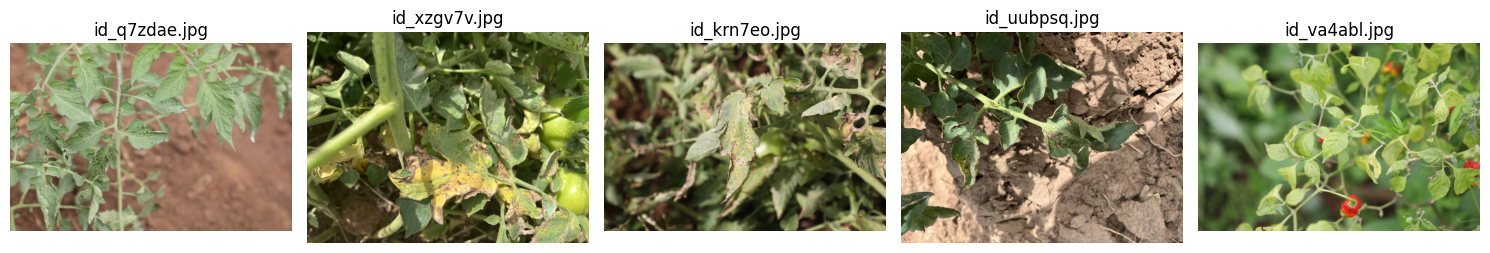

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

# Définir le chemin vers le dossier contenant les images
image_dir = '/kaggle/input/ghana-crop-disease/images/'

# Afficher quelques images aléatoires
sample_images = train['Image_ID'].sample(5).tolist()

plt.figure(figsize=(15, 10))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR à RGB
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')

plt.tight_layout()
plt.show()



In [4]:
import os

# Créer un dossier pour les fichiers d'annotation YOLO
yolo_annotations_dir = '/kaggle/working/yolo_annotations'
os.makedirs(yolo_annotations_dir, exist_ok=True)

# Créer un dictionnaire de classes
class_mapping = {label: idx for idx, label in enumerate(train['class'].unique())}

# Convertir les annotations
for img_id in train['Image_ID'].unique():
    img_annotations = train[train['Image_ID'] == img_id]
    
    # Obtenir les dimensions de l'image
    img_path = os.path.join(image_dir, img_id)
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    
    # Chemin du fichier d'annotation
    yolo_file_path = os.path.join(yolo_annotations_dir, img_id.replace('.jpg', '.txt'))
    
    with open(yolo_file_path, 'w') as f:
        for _, row in img_annotations.iterrows():
            # Calculer les coordonnées normalisées
            class_id = class_mapping[row['class']]
            x_center = (row['xmin'] + row['xmax']) / 2 / width
            y_center = (row['ymin'] + row['ymax']) / 2 / height
            box_width = (row['xmax'] - row['xmin']) / width
            box_height = (row['ymax'] - row['ymin']) / height
            
            # Écrire l'annotation au format YOLO
            f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")

print("Conversion des annotations terminée !")


Conversion des annotations terminée !


In [20]:
import shutil

# Créer les dossiers pour le dataset
dataset_dir = '/kaggle/working/dataset'
images_train_dir = os.path.join(dataset_dir, 'images/train')
images_val_dir = os.path.join(dataset_dir, 'images/val')
labels_train_dir = os.path.join(dataset_dir, 'labels/train')
labels_val_dir = os.path.join(dataset_dir, 'labels/val')

os.makedirs(images_train_dir, exist_ok=True)
os.makedirs(images_val_dir, exist_ok=True)
os.makedirs(labels_train_dir, exist_ok=True)
os.makedirs(labels_val_dir, exist_ok=True)

# Séparer les données en ensembles d'entraînement et de validation (80/20)
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(train['Image_ID'].unique(), test_size=0.2, random_state=42)

# Déplacer les images et labels
for img_id in train['Image_ID'].unique():
    img_path = os.path.join(image_dir, img_id)
    if img_id in train_ids:
        shutil.copy(img_path, images_train_dir)
        shutil.copy(os.path.join(yolo_annotations_dir, img_id.replace('.jpg', '.txt')), labels_train_dir)
    else:
        shutil.copy(img_path, images_val_dir)
        shutil.copy(os.path.join(yolo_annotations_dir, img_id.replace('.jpg', '.txt')), labels_val_dir)

print("Données séparées en ensembles d'entraînement et de validation.")


Données séparées en ensembles d'entraînement et de validation.


In [25]:
# Vérifier si le répertoire dataset existe
dataset_dir = '/kaggle/working/dataset'
os.makedirs(dataset_dir, exist_ok=True)  # Créer le répertoire si nécessaire

# Créer le fichier de configuration
config_file_path = os.path.join(dataset_dir, 'config.yaml')
try:
    with open(config_file_path, 'w') as f:
        f.write("train: ../images/train\n")
        f.write("val: ../images/val\n")
        f.write("\n")
        f.write("nc: {}\n".format(len(class_mapping)))  # Nombre de classes
        f.write("names: {}\n".format(list(class_mapping.keys())))  # Noms des classes

    print("Fichier de configuration créé avec succès.")
except Exception as e:
    print("Erreur lors de la création du fichier de configuration :", e)


Fichier de configuration créé avec succès.


In [29]:
# Naviguer vers le répertoire contenant train.py
%cd /kaggle/input/yolov5/pytorch/default/1/yolov5-master

# Installer les dépendances requises
!pip install -r requirements.txt


/kaggle/input/yolov5/pytorch/default/1/yolov5-master
ERROR: Could not find a version that satisfies the requirement thop>=0.1.1 (from versions: none)
ERROR: No matching distribution found for thop>=0.1.1


In [31]:
# Entraîner le modèle
!python train.py --img 640 --batch 16 --epochs 50 --data /kaggle/working/dataset/config.yaml --weights yolov5s.pt --cache


ERROR: Could not find a version that satisfies the requirement ultralytics (from versions: none)
ERROR: No matching distribution found for ultralytics
Traceback (most recent call last):
  File "/kaggle/input/yolov5/pytorch/default/1/yolov5-master/models/common.py", line 27, in <module>
    import ultralytics
ModuleNotFoundError: No module named 'ultralytics'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/kaggle/input/yolov5/pytorch/default/1/yolov5-master/train.py", line 47, in <module>
    import val as validate  # for end-of-epoch mAP
  File "/kaggle/input/yolov5/pytorch/default/1/yolov5-master/val.py", line 39, in <module>
    from models.common import DetectMultiBackend
  File "/kaggle/input/yolov5/pytorch/default/1/yolov5-master/models/common.py", line 34, in <module>
    import ultralytics
ModuleNotFoundError: No module named 'ultralytics'
